In [2]:
import os
import os.path as osp
import skimage.io
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
path = '../public_data'

In [4]:
label_names = [file for file in os.listdir(path) if file.endswith('.json')]
feature_names = [name.replace('.json', '.tiff') for name in label_names]

In [9]:
img = skimage.io.imread(osp.join(path, feature_names[50]))

In [10]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(img.reshape(-1, 3))
res = kmeans.labels_.reshape(257, 257, -1)

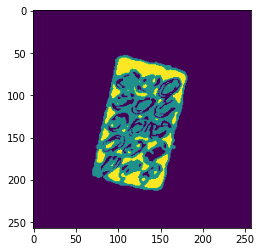

In [12]:
plt.imshow(res)